# Import Modules

In [1]:
import time
from zipfile import ZipFile
import json
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
plt.style.use('dark_background')

Found GPU at: /device:GPU:0


# Functions Definition

## Datasets Tools

In [2]:
def print_dataset_info(name, x_train, y_train, x_test, y_test):
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f'{name} dataset information:')
    print(f'  * Total Train Samples: {train_samples}')
    print(f'  * Total Test Samples:  {test_samples}')
    print(f'  * Input Shape:  {x_train.shape[1:]}')
    print(f'  * Output Shape: {y_train.shape[1:]}')
    print(f'Shapes Detail:')
    print(f'  * x_train:  {x_train.shape}')
    print(f'  * y_train:  {y_train.shape}')
    print(f'  * x_test:   {x_test.shape}')
    print(f'  * y_test:   {y_test.shape}')


def show_random_image(name, x_train, y_train, x_test, y_test):
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    if x_train.ndim == 4 and x_train.shape[-1] not in (3, 4):
        print(f'Invalid image shape {x_train.shape[1:]} for image data')
        x_train = x_train.reshape(x_train.shape[:-1])
        x_test = x_test.reshape(x_test.shape[:-1])
        print(f'Images reshaped to: {x_train.shape[1:]}')
    print('Random Train Example: ')
    index = np.random.randint(0, train_samples)
    plt.imshow(x_train[index, ])
    plt.show()
    print(f'Label: {y_train[index,]}')
    print('Random Test Example: ')
    index = np.random.randint(0, test_samples)
    plt.imshow(x_test[index, ])
    plt.show()
    print(f'Label: {y_test[index,]}')


def print_cifar10_classes():
    num_classes = 10
    classes = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }
    print('CIFAR10 Classes:')
    for i in range(num_classes):
        print(f'  {i}- {classes[i]}')


## Train Tools

In [15]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def save_run_info(model, history, optimizer, dataset: str, comment=None):
    # Load Data
    model_name = model.name
    optimizer_name = optimizer.get_config()['name']
    model_config = model.to_json()
    history_dict = {}
    epochs = len(history.history['loss'])
    history_dict['epochs'] = list(range(1, epochs+1))
    history_dict.update(history.history)
    optimizer_config = optimizer.get_config()
    for i in optimizer_config:
        if type(optimizer_config[i]) not in (str, float) :
            optimizer_config[i] = round(float(optimizer_config[i]), 4)
    print(optimizer_config)     
    # Serializing
    max_acc = round(max(history_dict['accuracy']), 2)
    max_val_acc = round(max(history_dict['val_accuracy']), 2)
    acc_str = f'{max_val_acc:.2f}{max_acc:.2f}'.replace('.', '')
    time_str = time.strftime("%Y%m%d_%H%M%S")
    zipfile_name = f'{dataset}_{model_name}_{acc_str}_{optimizer_name}_{time_str}.zip'
    history_df = pd.DataFrame(history_dict)
    with ZipFile(zipfile_name, mode='w') as zip_file:
        zip_file.writestr(f'history.csv', history_df.to_csv(index=False))
        zip_file.writestr(f'dataset.txt', dataset)
        zip_file.writestr(f'model_config.json',
                          json.dumps(model_config, indent=4))
        zip_file.writestr(f'optimizer_config.json',
                          json.dumps(optimizer_config, indent=4))
        if comment:
            zip_file.writestr('comment.txt', comment)


# Optimizers Classes

In [4]:
class Gravity(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate, beta=0.9, name="Gravity", **kwargs):
        super(Gravity, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta', beta)
        self.epsilon = 1e-7
    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, "velocity")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        # Get Data
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        beta = self._get_hyper("beta", var_dtype)
        velocity = self.get_slot(var, "velocity")

        # Calculations
        max_step_grad = 1/(tf.reduce_max(tf.abs(grad))+self.epsilon)
        gradient_term = grad / (1 + (grad/(max_step_grad+self.epsilon))**2)

        # update variables
        updated_velocity = velocity.assign(beta*velocity + (1-beta)*gradient_term) 
        updated_var = var.assign(var - lr_t*updated_velocity)       
        
        updates = [updated_var, updated_velocity]
        # return tf.group(*updates)
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        config = super(Gravity, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta': self._serialize_hyperparameter('beta'),
            'epsilon': self.epsilon,
        })
        return config

In [5]:
class TestOpt(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate, beta=0.9, name="Gravity", **kwargs):
        super(TestOpt, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('beta', beta)
        self.epsilon = 1e-7
    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, "velocity")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        # Get Data
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        beta = self._get_hyper("beta", var_dtype)
        velocity = self.get_slot(var, "velocity")

        # Calculations
        m = 1 # Gradient at which the learning rate is half of the max
        gradient_term = (grad*((grad/(m+self.epsilon))**2)+0.001) / (1 + (grad/(m+self.epsilon))**2)

        # update variables
        updated_velocity = velocity.assign(beta*velocity + (1-beta)*gradient_term) 
        updated_var = var.assign(var - lr_t*updated_velocity)       
        
        updates = [updated_var, updated_velocity]
        # return tf.group(*updates)
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        config = super(TestOpt, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta': self._serialize_hyperparameter('beta'),
            'epsilon': self.epsilon,
        })
        return config

In [6]:
class Pace(tf.keras.optimizers.Optimizer):
    def __init__(self, lr, name="AdaptivePace", **kwargs):
        super().__init__(name, **kwargs)
        self.learning_rate = lr
        self.epsilon = 1e-7
        self.pace_log = {'min':[], 'max':[], 'mean':[], 'std':[]}
    
    def _create_slots(self, var_list):
        pass

    @tf.function
    def _resource_apply_dense(self, grad, var):
        b = self.learning_rate
        a = b*abs(float(tf.math.reduce_std(grad)))
        step = -a*tf.math.tanh((b/a)*grad)
        updated_var = step + var
        var.assign(updated_var)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        base_config = super().get_config()
        return base_config

# Datasets

In [7]:
tf.keras.backend.set_image_data_format('channels_last')

## MNIST

11493376/11490434 [==============================] - 0s 0us/step
MNIST dataset information:
  * Total Train Samples: 60000
  * Total Test Samples:  10000
  * Input Shape:  (28, 28, 1)
  * Output Shape: ()
Shapes Detail:
  * x_train:  (60000, 28, 28, 1)
  * y_train:  (60000,)
  * x_test:   (10000, 28, 28, 1)
  * y_test:   (10000,)
Invalid image shape (28, 28, 1) for image data
Images reshaped to: (28, 28)
Random Train Example: 


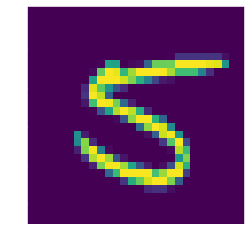

Label: 5
Random Test Example: 


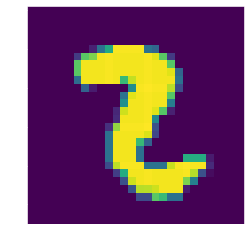

Label: 2


In [8]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
x_train_mnist = x_train_mnist.reshape((x_train_mnist.shape[0], 28, 28, 1)).astype('float32')
x_test_mnist = x_test_mnist.reshape((x_test_mnist.shape[0], 28, 28, 1)).astype('float32')
x_train_mnist, x_test_mnist = x_train_mnist / 255.0, x_test_mnist / 255.0
input_shape_mnist = x_train_mnist.shape[1:]
classes_mnist = 10
print_dataset_info('MNIST', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)
show_random_image('MNIST', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)

## CIFAR 10

170500096/170498071 [==============================] - 2s 0us/step
CIFAR10 dataset information:
  * Total Train Samples: 50000
  * Total Test Samples:  10000
  * Input Shape:  (32, 32, 3)
  * Output Shape: (1,)
Shapes Detail:
  * x_train:  (50000, 32, 32, 3)
  * y_train:  (50000, 1)
  * x_test:   (10000, 32, 32, 3)
  * y_test:   (10000, 1)
CIFAR10 Classes:
  0- airplane
  1- automobile
  2- bird
  3- cat
  4- deer
  5- dog
  6- frog
  7- horse
  8- ship
  9- truck
Random Train Example: 


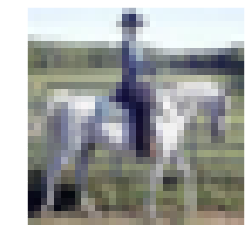

Label: [7]
Random Test Example: 


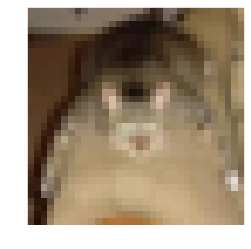

Label: [3]


In [9]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = tf.keras.datasets.cifar10.load_data()
x_train_cifar10 = x_train_cifar10.astype('float32')
x_test_cifar10 = x_test_cifar10.astype('float32')
x_train_cifar10, x_test_cifar10= x_train_cifar10 / 255, x_test_cifar10 / 255
input_shape_cifar10 = x_train_cifar10.shape[1:]
classes_cifar10 = 10
print_dataset_info('CIFAR10', x_train_cifar10, y_train_cifar10, x_test_cifar10, y_test_cifar10)
print_cifar10_classes()
show_random_image('CIFAR10', x_train_cifar10, y_train_cifar10, x_test_cifar10, y_test_cifar10)


# Achitectures

## VGG16 (CIFAR10)

In [10]:
def get_vgg16_cifar10(print_summary=True):
    model_vgg16_cifar10 = tf.keras.applications.VGG16(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=input_shape_cifar10,
        pooling=None,
        classes=classes_cifar10,
        classifier_activation=None,
    )
    if print_summary:
        model_vgg16_cifar10.summary()
    return model_vgg16_cifar10

# Optimizers Test

In [11]:
sparse_categorical_cost = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Optimizers Instantiation

### Adam

In [12]:
adam_learning_rate = 0.1
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_epsilon = 1e-07
adam_amsgrad = False

adam_opt = tf.keras.optimizers.Adam(
    learning_rate=adam_learning_rate,
    beta_1=adam_beta_1,
    beta_2=adam_beta_2,
    epsilon=adam_epsilon,
    amsgrad=adam_amsgrad
)

### Gravity

In [22]:
gravity_learning_rate = 0.1
gravity_beta = 0.999
gravity_opt = Gravity(gravity_learning_rate, beta=gravity_beta)

### Test Opt

In [ ]:
test_lr = 0.01
test_beta = 0
test_opt = TestOpt(test_lr, beta=test_beta)

## CIFAR10 Test

### Hyper Parameters

In [17]:
batch_size_cifar10 = 128
epochs_cifar10 = 100

### Adam Test

In [ ]:
model_vgg16_cifar10_adam = get_vgg16_cifar10(print_summary=False)

model_vgg16_cifar10_adam.compile(optimizer=adam_opt,
                                 loss=sparse_categorical_cost,
                                 metrics=['accuracy'])
adam_history = model_vgg16_cifar10_adam.fit(x_train_cifar10, y_train_cifar10,
                                            batch_size=batch_size_cifar10,
                                            epochs=epochs_cifar10,
                                            validation_data=(x_test_cifar10, y_test_cifar10))

Epoch 1/100
391/391 [==============================] - 52s 133ms/step - loss: 21385292283904.0000 - accuracy: 0.0996 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 2/100
391/391 [==============================] - 50s 128ms/step - loss: 2.3048 - accuracy: 0.1009 - val_loss: 2.3037 - val_accuracy: 0.1000
Epoch 3/100
391/391 [==============================] - 50s 128ms/step - loss: 2.3053 - accuracy: 0.0996 - val_loss: 2.3054 - val_accuracy: 0.1000
Epoch 4/100
391/391 [==============================] - 50s 127ms/step - loss: 2.3064 - accuracy: 0.0989 - val_loss: 2.3073 - val_accuracy: 0.1000
Epoch 5/100
391/391 [==============================] - 50s 127ms/step - loss: 2.3066 - accuracy: 0.0999 - val_loss: 2.3055 - val_accuracy: 0.1000
Epoch 6/100
391/391 [==============================] - 50s 127ms/step - loss: 2.3068 - accuracy: 0.1017 - val_loss: 2.3078 - val_accuracy: 0.1000
Epoch 7/100
391/391 [==============================] - 50s 127ms/step - loss: 2.3079 - accuracy: 0.0975 - val_l

KeyboardInterrupt: ignored

### Gravity Test

In [23]:
model_vgg16_cifar10_gravity = get_vgg16_cifar10(print_summary=False)

model_vgg16_cifar10_gravity.compile(optimizer=gravity_opt,
                                    loss=sparse_categorical_cost,
                                    metrics=['accuracy'])
gravity_history = model_vgg16_cifar10_gravity.fit(x_train_cifar10, y_train_cifar10,
                                                  batch_size=batch_size_cifar10,
                                                  epochs=epochs_cifar10,
                                                  validation_data=(x_test_cifar10, y_test_cifar10))

Epoch 1/100
391/391 [==============================] - 28s 72ms/step - loss: 2.3026 - accuracy: 0.0989 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 2.3026 - accuracy: 0.0999 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 3/100
391/391 [==============================] - 29s 73ms/step - loss: 2.3023 - accuracy: 0.1155 - val_loss: 2.3020 - val_accuracy: 0.1325
Epoch 4/100
391/391 [==============================] - 29s 73ms/step - loss: 2.3014 - accuracy: 0.1185 - val_loss: 2.2999 - val_accuracy: 0.1216
Epoch 5/100
391/391 [==============================] - 29s 73ms/step - loss: 2.2928 - accuracy: 0.1556 - val_loss: 2.2734 - val_accuracy: 0.1666
Epoch 6/100
391/391 [==============================] - 29s 73ms/step - loss: 2.1917 - accuracy: 0.1726 - val_loss: 2.1405 - val_accuracy: 0.1897
Epoch 7/100
391/391 [==============================] - 29s 73ms/step - loss: 2.1119 - accuracy: 0.1975 - val_loss: 2.0925 - val_ac

In [25]:
comment = f"""Batch Size: {batch_size_cifar10}
max_step_grad=1/(tf.reduce_max(tf.abs(grad))+self.epsilon)"""
save_run_info(model_vgg16_cifar10_gravity,
              gravity_history,
              gravity_opt,
              'CIFAR10',
              comment=comment)

{'name': 'Gravity', 'learning_rate': 0.1, 'decay': 0.0, 'beta': 0.999, 'epsilon': 1e-07}


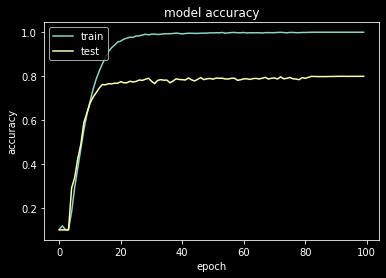

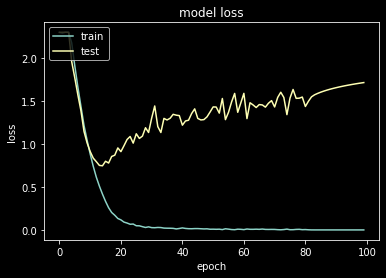

In [ ]:
plot_history(gravity_history)

### Test Optimizer

In [ ]:
model_vgg16_cifar10_test = get_vgg16_cifar10(print_summary=False)

model_vgg16_cifar10_test.compile(optimizer=test_opt,
                                    loss=sparse_categorical_cost,
                                    metrics=['accuracy'])
test_history = model_vgg16_cifar10_test.fit(x_train_cifar10, y_train_cifar10,
                                            batch_size=batch_size_cifar10,
                                            epochs=epochs_cifar10,
                                            validation_data=(x_test_cifar10, y_test_cifar10))

In [ ]:
comment = f"""Batch Size: {batch_size_cifar10}
max_step_grad=1/(tf.reduce_max(tf.abs(grad))+self.epsilon)"""
save_run_info(model_vgg16_cifar10_gravity,
              gravity_history,
              gravity_opt,
              'CIFAR10',
              comment=comment)

{'name': 'Gravity', 'learning_rate': 0.1, 'decay': 0.0, 'beta': 0.9, 'epsilon': 0.0}


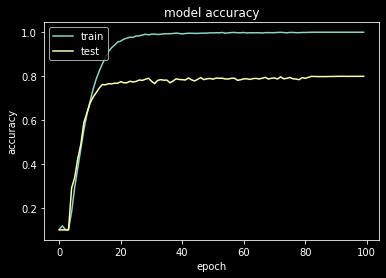

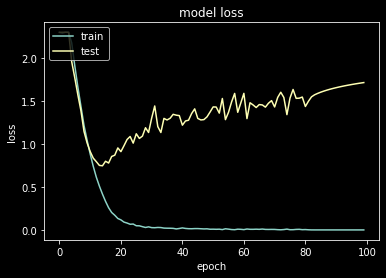

In [ ]:
plot_history(gravity_history)